## 0. Inporting Packages

In [1]:

path='G:/Shared drives/BeStarsMiMeS/ScienceFiles/' #Patrick's google file stream path
#import LSDpy.lsdpy
#import specpolFlow as pol


import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import itertools

import pyRaven as rav
import scipy

In [2]:
#Accessing the google sheets

sheet_id = '1M6y1Wnsrc-w5FjUMfKaSFa_-foIDAaMe8W4lYNWnWyk'
sheet_name = 'Stars'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
StarData=pd.read_csv(url)

sheet_name = 'Observations'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
Observations=pd.read_csv(url)

In [3]:
fname='{}.h5'.format('hd35411')
DataPacket=rav.data.read_packet(fname)
guess=np.array([0.4,0.51,60,30,30,30,-40,90,-40,90,-40,90])

[array([0.99999291, 0.99999291, 0.99999291, 0.99999291, 0.99999291,
        0.99999291, 0.99999072, 0.99998629, 0.99998385, 0.99998216,
        0.99998047, 0.99997863, 0.99997662, 0.99997439, 0.99997191,
        0.99996913, 0.999966  , 0.99996242, 0.99995829, 0.99995344,
        0.99994765, 0.99994058, 0.99993165, 0.99991972, 0.99990074,
        0.99985067, 0.99965397, 0.99898737, 0.99741595, 0.99485784,
        0.99180132, 0.98883373, 0.98619311, 0.98385225, 0.98173974,
        0.9798104 , 0.97803873, 0.97640887, 0.97490993, 0.97353407,
        0.97227538, 0.97112929, 0.97009221, 0.96916127, 0.96833415,
        0.96760899, 0.96698426, 0.96645873, 0.96603144, 0.96570162,
        0.96546871, 0.96533232, 0.96529223, 0.96534837, 0.96550084,
        0.96574988, 0.96609592, 0.96653954, 0.96708154, 0.96772293,
        0.96846498, 0.96930927, 0.97025774, 0.97131279, 0.97247739,
        0.97375528, 0.97515121, 0.97667137, 0.97832403, 0.98012071,
        0.98207847, 0.98422518, 0.98661062, 0.98

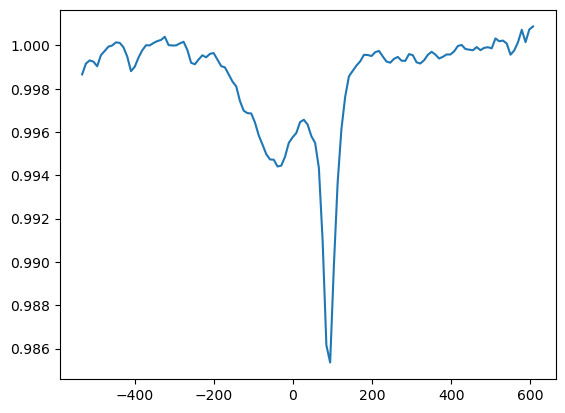

In [6]:
#inputs

#param_to_fit = [['vsini','logkappa','vrad','vmac'],['vsini','logkappa','vrad','vmac']] #[[star1],[star2]]
#guess = [[60,np.log(0.4),[-40,-40,-40],30],[30,np.log(0.51),[90,90,90],30]]
#bounds = [[(0,300),(None,None),[(-300,300),(-300,300),(-300,300)],(0,40)],[(0,300),(None,None),[(-300,300),(-300,300),(-300,300)],(0,40)]]
nobs=DataPacket.nobs
param_to_fit = [['vsini','logkappa','vmac'],['vsini','logkappa','vmac','vrad']] #[[star1],[star2]]
guess = [[60,np.log(0.4),30],[30,np.log(0.51),30,[90,90,90]]]
bounds = [[(0,300),(None,None),(0,40)],[(0,300),(None,None),(0,40),[(-300,300)]*nobs]]

genparam = {
    'lambda0':5811.969,    # the central wavelength of the transition
    'vsini':224.52037414,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':np.log(1.3),          # the line strength parameter
    'Bpole':1.0e1,         # the dipolar field strength
    'incl':np.pi/4,      # the inclination of the rotational axis to the line of sight
    'beta':np.pi/4,      # the obliquity of the magnetic axis to the rotational axis
    'phase':0.0,     # the rotational phase
    'ndop':int(100),       # the number of sample point per doppler width for the wavelength array
    'vrad':[21.64485053,-3.79984201,39.87704611]
    }
unnoparam = {
    'down':[0.5,0, 0.5],   # the s, j, l of the lower level
    'up':[0.5, 1, 0.5]    # the s, j, l of the upper level
    }
weakparam = {
    'geff':1.0,
    }
param={'general' : genparam,
    'unno' : unnoparam,
    'weak' : weakparam}
param['general'].update({'res': 65000.})
param['general'].update({'vmac': 10.})
param['general'].update({'vrad': [-40,-40,-40]})

parameters=[param,param]


xs=[]
ys=[]
ys_err=[]
for o in range(DataPacket.nobs):
    xs.append(DataPacket.scaled.lsds[o].vel)
    ys.append(DataPacket.scaled.lsds[o].specI)
    ys_err.append(DataPacket.scaled.lsds[o].specSigI)


xs[1]=np.append(xs[1],0)
ys[1]=np.append(ys[1],0)
ys_err[1]=np.append(ys_err[1],0)

lsds=[xs,ys,ys_err]

#two,one,ui=fun(res.x,param_to_fit,parameters,DataPacket)
#one,ui,star=fun(np.append(np.hstack(guess[0]),np.hstack(guess[1])),param_to_fit,parameters,DataPacket,guess)
#plt.plot(np.hstack(xs),np.hstack(ys))
#plt.plot(np.hstack(xs),two)

#plt.plot(xs[0],ui[0])
#plt.plot(xs[0],ui[3])
plt.plot(xs[0],ys[0])

rav.fitparams.param_to_model(parameters,lsds)

In [29]:
import numpy as np
import scipy
import copy
import pyRaven as rav

def update_params(theta_,fitparam,param,nobs,guess):
    '''
    This function makes a copy of the param object and updates it based on the input parameters.
    Inputs:
    :theta_: a list of lists containing parameters to update the param object with. The structure is as follows: [[star1 parameters],[star2 parameters],...]
    :*p: is a set of additional input parameters, listed below.
        :fitparam: list of lists of strings indicating which parameters to fit for which stars 
        :param: list of param objects for each star to fit
        :DataPacket: the datapacket for the object
        :guess: a list of lists containing the original guess parameters in the same order and format as theta_

    Outputs:
    :star: a list of param objects containing the new parameters (in the same format as param)
    
    '''

    star=[]
    prev=0
    for j in range(len(fitparam)): #loop over stars
        k=0
        star.append(copy.deepcopy(param[j])) 
        for i,n in enumerate(fitparam[j]): #loop over parameters that are being fit (skipping vrad for now)
            if n != 'vrad':
                star[j]['general'][n]=theta_[prev+i+k]
            if n == 'vrad':
                k=nobs-1
                vrads=[]
                for o in range(nobs):
                    vrads.append(theta_[i+prev+o])
                star[j]['general']['vrad']=vrads
         
        prev+=len(np.hstack(guess[j]))

    return(star)

def param_to_model(parameters,lsds):
    '''
    This function models the multi-star LSD profile given the input list of param objects

    Inputs:
    :parameters: a list of param objects to model
    :lsds: a list with the format: [[vels],[specIs],[specSigIs]]

    Outputs: 
    :fitmodels: list of stokes I values for the fit model per observation
    '''
    vel=lsds[0]
    specI=lsds[1]
    specSigI=lsds[2]
    nobs=int(len(lsds[0]))

    fitmodels=[]
    fys=[]
    for j in range(len(parameters)):
        model=rav.diskint.analytical(parameters[j],False)
        for o in range(DataPacket.nobs):
            fys.append(np.interp(vel[o],model['vel']+parameters[j]['general']['vrad'][o],model['flux']))
    
    for o in range(nobs):
        obs=np.zeros(len(fys[0]))
        for j in range(len(parameters)):
            obs+=fys[o+(nobs)*j]
        fitmodels.append(obs-j)
    return(fitmodels)

def chi2(theta_,*p):
    '''
    Helper function that calculates the chi2 used by scipy.optimize.minimize

    Inputs:
    :theta_: list of lists containing the parameters to test
    :*p: is a set of additional input parameters, listed below.
        :fitparam: list of lists of strings indicating which parameters to fit for which stars 
        :param: list of param objects for each star to fit
        :lsds: a list with the format: [[vels],[specIs],[specSigIs]]
        :guess: a list of lists containing the original guess parameters in the same order and format as theta_

    Outputs:
    :chi2: the chi2 value 

    '''

    fitparam=p[0]
    param=p[1]
    lsds=p[2]
    guess=p[3]
    nobs=int(len(lsds[0]))

    ys=[]
    ys_err=[]

    for o in range(nobs):
        ys.append(lsds[1][o])
        ys_err.append(lsds[2][o])

    star=update_params(theta_,fitparam,param,nobs,guess)
    fitmodels=param_to_model(star,lsds)
    
    models=np.hstack(fitmodels) 
    chi2=(np.sum((models-np.hstack(ys))**2/np.hstack(ys_err)))
    return(chi2)

def fitting(param_to_fit,parameters,lsds,guess,bounds):
    '''
    The actual fitting routine

    Inputs:
    :param_to_fit: list of list of strings stating which parameters should be fit for each star
    :parameters: list of param objects for each star
    :DataPacket: datapacket for the object
    :guess: list of lists containing the initial guess values for each parameter to fit and each star
    :bounds: list of lists of tuples containing the bounds to use for each parameter to fit

    Outputs:
    :res: the output from scipy.optimize.minimize
    :star: list of param objects for each star containing the final fit values

    '''

    nobs=int(len(lsds[0]))
    bound=[]
    guesses=np.array([])
    for j in range(len(param_to_fit)):
        guesses=np.append(guesses,np.hstack(guess[j]))
        for i,n in enumerate(param_to_fit[j]):
            if n!='vrad':
                bound.append(bounds[j][i])
            if n=='vrad':
                for o in range(nobs):
                    bound.append(bounds[j][np.where(np.array(param_to_fit[j])=='vrad')[0][0]][o])

    res=scipy.optimize.minimize(chi2,guesses,args=(param_to_fit,parameters,lsds,guess),bounds=bound)

    star=update_params(res.x,param_to_fit,parameters,nobs,guess)
    return(res,star)



In [30]:
res,star=fitting(param_to_fit,parameters,lsds,guess,bounds)

In [33]:
res.x

array([207.66925407,  -0.5930959 ,  40.        ,   5.06830405,
        -1.02921583,  14.52663901,  91.05812198,   1.96963054,
       101.89049608])

In [26]:
res.x

array([203.71514608,  -0.60841252,  40.        ,   5.1189602 ,
        -1.        ,  15.52573922,  91.10296188,   2.01707785,
       102.1332414 ])

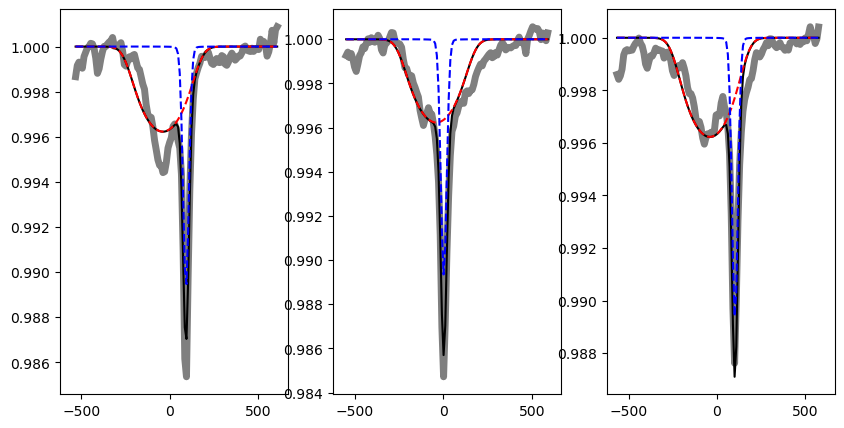

In [41]:
xs=[]
ys=[]
for o in range(DataPacket.nobs):
    xs.append(DataPacket.scaled.lsds[o].vel)
    ys.append(DataPacket.scaled.lsds[o].specI)

fitmodels=param_to_model(star,lsds)
fit1=param_to_model([star[0]],lsds)
fit2=param_to_model([star[1]],lsds)

fig, ax = plt.subplots(1,3,sharex=True,figsize=(10,5))

ax[0].plot(xs[0],fitmodels[0],color='black')
ax[0].plot(xs[0],fit1[0],color='red',linestyle='dashed')
ax[0].plot(xs[0],fit2[0],color='blue',linestyle='dashed')
ax[0].plot(xs[0],ys[0],linewidth=5,color='black',alpha=0.5,zorder=0)

ax[1].plot(xs[1],fitmodels[1],color='black')
ax[1].plot(xs[1],fit1[1],color='red',linestyle='dashed')
ax[1].plot(xs[1],fit2[1],color='blue',linestyle='dashed')
ax[1].plot(xs[1],ys[1],linewidth=5,color='black',alpha=0.5,zorder=0)

ax[2].plot(xs[2],fitmodels[2],color='black')
ax[2].plot(xs[2],fit1[2],color='red',linestyle='dashed')
ax[2].plot(xs[2],fit2[2],color='blue',linestyle='dashed')
ax[2].plot(xs[2],ys[2],linewidth=5,color='black',alpha=0.5,zorder=0)


In [4]:
## Defines star 1 parameters
genparam = {
    'lambda0':5811.969,    # the central wavelength of the transition
    'vsini':100,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':np.log(1.3),          # the line strength parameter
    'Bpole':1.0e1,         # the dipolar field strength
    'incl':np.pi/4,      # the inclination of the rotational axis to the line of sight
    'beta':np.pi/4,      # the obliquity of the magnetic axis to the rotational axis
    'phase':0.0,     # the rotational phase
    'ndop':int(100),       # the number of sample point per doppler width for the wavelength array
    }
unnoparam = {
    'down':[0.5,0, 0.5],   # the s, j, l of the lower level
    'up':[0.5, 1, 0.5]    # the s, j, l of the upper level
    }
weakparam = {
    'geff':1.0,
    }
param1={'general' : genparam,
    'unno' : unnoparam,
    'weak' : weakparam}
param1['general'].update({'res': 65000.})
param1['general'].update({'vmac': 10.})

## defines star 2 parameters
genparam2 = {
    'lambda0':5811.969,    # the central wavelength of the transition
    'vsini':50,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':np.log(1.3),          # the line strength parameter
    'Bpole':1.0e1,         # the dipolar field strength
    'incl':np.pi/4,      # the inclination of the rotational axis to the line of sight
    'beta':np.pi/4,      # the obliquity of the magnetic axis to the rotational axis
    'phase':0.0,     # the rotational phase
    'ndop':int(100),       # the number of sample point per doppler width for the wavelength array
    }
unnoparam2 = {
    'down':[0.5,0, 0.5],   # the s, j, l of the lower level
    'up':[0.5, 1, 0.5]    # the s, j, l of the upper level
    }
weakparam2 = {
    'geff':1.0,
    }
param2={'general' : genparam2,
    'unno' : unnoparam2,
    'weak' : weakparam2}
param2['general'].update({'res': 65000.})
param2['general'].update({'vmac': 10.})

In [5]:

x1=DataPacket.scaled.lsds[0].vel
y1=DataPacket.scaled.lsds[0].specI
x2=DataPacket.scaled.lsds[1].vel
y2=DataPacket.scaled.lsds[1].specI
x3=DataPacket.scaled.lsds[2].vel
y3=DataPacket.scaled.lsds[2].specI
y1err=DataPacket.scaled.lsds[0].specSigI
y2err=DataPacket.scaled.lsds[1].specSigI
y3err=DataPacket.scaled.lsds[2].specSigI

In [6]:
guess=np.array([0.4,0.51,60,30,30,30,-40,90,-40,90,-40,90])
pout,pcov,binary_models,star1_models,star2_models=rav.fitparams.binary_fitting([x1,x2,x3],[y1,y2,y3],guess,param1,param2)

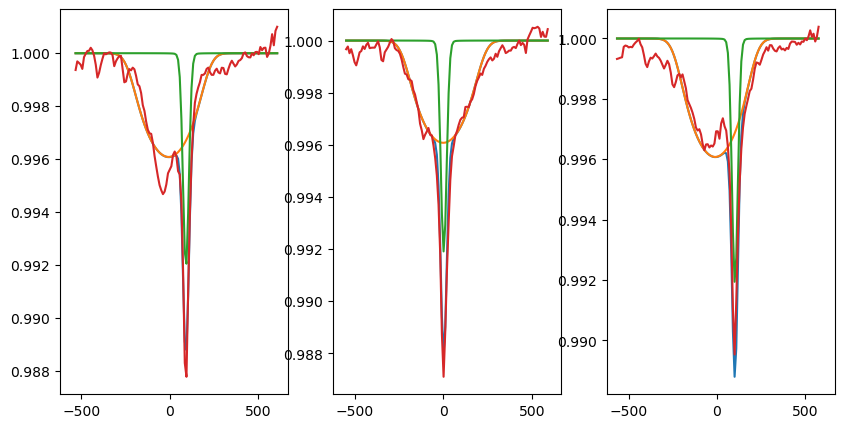

In [21]:
kappa1=pout[0]
kappa2=pout[1]
vsini1=pout[2]
vsini2=pout[3]
vmac1=pout[4]
vmac2=pout[5]
fig, ax = plt.subplots(1,3,sharex=True,figsize=(10,5))

ax[0].plot(x1,binary_models[0][0])
ax[0].plot(x1,star1_models[0][0])
ax[0].plot(x1,star2_models[0][0])
ax[0].plot(x1,y1)

ax[1].plot(x2,binary_models[1][0])
ax[1].plot(x2,star1_models[1][0])
ax[1].plot(x2,star2_models[1][0])
ax[1].plot(x2,y2)

ax[2].plot(x3,binary_models[2][0])
ax[2].plot(x3,star1_models[2][0])
ax[2].plot(x3,star2_models[2][0])
ax[2].plot(x3,y3)

## 2. Loop over all binaries - UPDATE

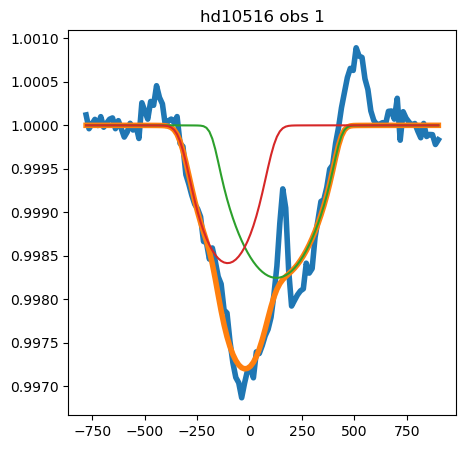

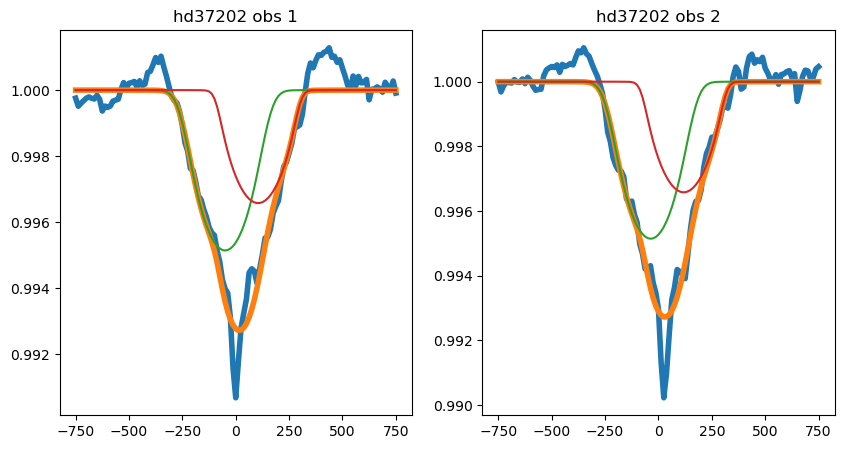

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'G:/Shared drives/BeStarsMiMeS/ScienceFiles/05-RavenSetup/normalized_maskdepth0.02_tellClean/hd35411.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [18]:
binaries = ['hd10516','hd37202','hd35411']

for i in range(3):
    fname='{}05-RavenSetup/normalized_maskdepth0.02_tellClean/{}.h5'.format(path,binaries[i])
    DataPacket=rav.data.read_packet(fname)
    nobs=DataPacket.nobs

    param_to_fit = [['vsini','logkappa','vrad','vmac'],['vsini','logkappa','vrad','vmac']] #[[star1],[star2]]
    guess = [[60,np.log(0.4),[-40]*nobs,30],[30,np.log(0.51),[90]*nobs,30]]
    bounds = [[(0,300),(None,None),[(-300,300)]*nobs,(0,40)],[(0,300),(None,None),[(-300,300)]*nobs,(0,40)]]

    genparam = {
        'lambda0':5811.969,    # the central wavelength of the transition
        'vsini':224.52037414,         # the projected rotational velocity
        'vdop':10.0,          # the thermal broadening
        'av':0.05,             # the damping coefficient of the Voigt profile
        'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
        'logkappa':np.log(1.3),          # the line strength parameter
        'Bpole':1.0e1,         # the dipolar field strength
        'incl':np.pi/4,      # the inclination of the rotational axis to the line of sight
        'beta':np.pi/4,      # the obliquity of the magnetic axis to the rotational axis
        'phase':0.0,     # the rotational phase
        'ndop':int(100),       # the number of sample point per doppler width for the wavelength array
        'vrad':[0,0,0]
        }
    unnoparam = {
        'down':[0.5,0, 0.5],   # the s, j, l of the lower level
        'up':[0.5, 1, 0.5]    # the s, j, l of the upper level
        }
    weakparam = {
        'geff':1.0,
        }
    param={'general' : genparam,
        'unno' : unnoparam,
        'weak' : weakparam}
    param['general'].update({'res': 65000.})
    param['general'].update({'vmac': 10.})
    param['general'].update({'vrad': [-40]*nobs})

    parameters=[param,param]

    res,star=rav.fitparams.fitting(param_to_fit,parameters,DataPacket,guess,bounds)

    xs=[]
    ys=[]
    for o in range(DataPacket.nobs):
        xs.append(DataPacket.scaled.lsds[o].vel)
        ys.append(DataPacket.scaled.lsds[o].specI)


    fitmodels=rav.fitparams.param_to_model(star,DataPacket)
    model1=rav.diskint.analytical(star[0],False)
    model2=rav.diskint.analytical(star[1],False)

    fig, ax = plt.subplots(1,nobs,sharex=True,figsize=(5*nobs,5))

    if nobs>1:
        for n in range(nobs):
            ax[n].plot(xs[n],ys[n],linewidth=4)
            ax[n].plot(xs[n],fitmodels[n],linewidth=4)
            star1=np.interp(DataPacket.scaled.lsds[n].vel,model1['vel']+star[0]['general']['vrad'][n],model1['flux'])
            star2=np.interp(DataPacket.scaled.lsds[n].vel,model2['vel']+star[1]['general']['vrad'][n],model2['flux'])
            ax[n].plot(xs[n],star1)
            ax[n].plot(xs[n],star2)
    
            ax[n].set_title('{} obs {}'.format(binaries[i],n+1))
    if nobs==1:
        n=0
        ax.plot(xs[n],ys[n],linewidth=4)
        ax.plot(xs[n],fitmodels[n],linewidth=4)
        star1=np.interp(DataPacket.scaled.lsds[n].vel,model1['vel']+star[0]['general']['vrad'][n],model1['flux'])
        star2=np.interp(DataPacket.scaled.lsds[n].vel,model2['vel']+star[1]['general']['vrad'][n],model2['flux'])
        ax.plot(xs[n],star1)
        ax.plot(xs[n],star2)
        
        ax.set_title('{} obs {}'.format(binaries[i],n+1))
    plt.show()